In [1]:
# Original Restormer-Tiny components (adapted from official code and paper)
import torch
import torch.nn as nn
import torch.nn.functional as F

class LayerNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mu = x.mean(1, keepdim=True)
        sigma = ((x - mu) ** 2).mean(1, keepdim=True)
        x = (x - mu) / torch.sqrt(sigma + self.eps)
        return self.weight[:, None, None] * x + self.bias[:, None, None]

class MDTA(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim * 3, kernel_size=1, bias=False)
        self.qkv_dwconv = nn.Conv2d(dim * 3, dim * 3, kernel_size=3, stride=1, padding=1, groups=dim * 3, bias=False)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=False)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv_dwconv(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)

        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)

        q = F.normalize(q, dim=2)
        k = F.normalize(k, dim=2)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = attn @ v
        out = out.reshape(B, C, H, W)
        out = self.project_out(out)
        return out

class GatedFFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden_dim = dim * 2
        self.project_in = nn.Conv2d(dim, hidden_dim * 2, kernel_size=1, bias=False)
        self.dwconv = nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, stride=1, padding=1, groups=hidden_dim * 2, bias=False)
        self.project_out = nn.Conv2d(hidden_dim, dim, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.project_in(x)
        x = self.dwconv(x)
        x1, x2 = x.chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = LayerNorm2d(dim)
        self.attn = MDTA(dim, num_heads)
        self.norm2 = LayerNorm2d(dim)
        self.ffn = GatedFFN(dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x




In [2]:
# ============ Restormer-Tiny ============
class RestormerTiny(nn.Module):
    def __init__(self, dim=32, num_blocks=4, scale=2, num_heads=2):
        super().__init__()
        self.shallow_feat = nn.Conv2d(3, dim, kernel_size=3, padding=1)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(dim, num_heads) for _ in range(num_blocks)])
        self.upsample = nn.Sequential(
            nn.Conv2d(dim, dim * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.Conv2d(dim, 3, 3, 1, 1)
        )

    def forward(self, x):
        x = self.shallow_feat(x)
        x = self.transformer_blocks(x)
        x = self.upsample(x)
        return x



In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, scale=2, transform=None):
        super().__init__()
        self.hr_images = [os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(".png")]
        self.scale = scale
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert("RGB")
        w, h = hr.size
        hr = hr.crop((0, 0, w - w % self.scale, h - h % self.scale))
        lr = hr.resize((w // self.scale, h // self.scale), Image.BICUBIC)
        return self.transform(lr), self.transform(hr)

In [5]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
from torchmetrics.functional import structural_similarity_index_measure as compute_ssim

def psnr(target, output, data_range=1.0):
    mse = np.mean((target - output) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(data_range / np.sqrt(mse))


def evaluate(model, dataloader, criterion=nn.MSELoss()):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    psnr_scores = []
    ssim_scores = []
    val_loss = 0.0

    with torch.no_grad():
        for lr_img, hr_img in dataloader:
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)
            sr_img = model(lr_img).clamp(0.0, 1.0)

            loss = criterion(sr_img, hr_img)
            val_loss += loss.item()

            psnr_val = psnr(hr_img.squeeze().cpu().numpy(), sr_img.squeeze().cpu().numpy())
            ssim_val = compute_ssim(sr_img, hr_img, data_range=1.0).item()

            psnr_scores.append(psnr_val)
            ssim_scores.append(ssim_val)

    avg_val_loss = val_loss / len(dataloader)
    return (
        sum(psnr_scores) / len(psnr_scores),
        sum(ssim_scores) / len(ssim_scores),
        avg_val_loss
    )


def plot_learning_curve(train_losses, val_losses, epoch_psnrs, epoch_ssims):
    plt.figure(figsize=(18, 5))

    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Curve')
    plt.legend()
    plt.grid(True)

    # Plot PSNR
    plt.subplot(1, 3, 2)
    plt.plot(range(1, len(epoch_psnrs) + 1), epoch_psnrs, label='Validation PSNR', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.title('Validation PSNR Curve')
    plt.legend()
    plt.grid(True)

    # Plot SSIM
    plt.subplot(1, 3, 3)
    plt.plot(range(1, len(epoch_ssims) + 1), epoch_ssims, label='Validation SSIM', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.title('Validation SSIM Curve')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def train(model, train_dataloader, val_dataloader, epochs=2, lr=1e-4, log_dir="runs/restormerTry"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    writer = SummaryWriter(log_dir)

    epoch_losses = []
    val_losses = []
    epoch_psnrs = []
    epoch_ssims = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        for lr_img, hr_img in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
            lr_img, hr_img = lr_img.to(device), hr_img.to(device)

            output = model(lr_img)
            loss = criterion(output, hr_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_dataloader)
        epoch_losses.append(avg_loss)
        writer.add_scalar("Loss/Train", avg_loss, epoch)

        val_psnr, val_ssim, val_loss = evaluate(model, val_dataloader, criterion)
        epoch_psnrs.append(val_psnr)
        epoch_ssims.append(val_ssim)
        val_losses.append(val_loss)

        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("PSNR/Val", val_psnr, epoch)
        writer.add_scalar("SSIM/Val", val_ssim, epoch)

        # Log images (first batch only)
        model.eval()
        with torch.no_grad():
            for lr_img, hr_img in val_dataloader:
                lr_img = lr_img.to(device)
                sr_img = model(lr_img).clamp(0.0, 1.0)
                writer.add_images("Input/LR", lr_img, epoch)
                writer.add_images("Output/SR", sr_img, epoch)
                writer.add_images("Target/HR", hr_img.to(device), epoch)
                break

        torch.cuda.empty_cache()

        if torch.cuda.is_available():
            allocated = torch.cuda.memory_allocated() / 1e6
            reserved = torch.cuda.memory_reserved() / 1e6
            print(f"[GPU] Memory allocated: {allocated:.2f} MB | reserved: {reserved:.2f} MB")

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Val Loss = {val_loss:.4f}, PSNR = {val_psnr:.2f}, SSIM = {val_ssim:.4f}")

    writer.close()
    plot_learning_curve(epoch_losses, val_losses, epoch_psnrs, epoch_ssims)
    return model


2025-05-01 22:49:07.628815: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746139747.651124     214 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746139747.657895     214 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
import cv2
import numpy as np
import torchvision.transforms as transforms

def visualize_cv2(model, dataloader, device):
    model.eval()
    lr, hr = next(iter(dataloader))
    lr_tensor = lr.to(device)

    with torch.no_grad():
        sr = model(lr_tensor).cpu()

    # Take one sample from the batch
    for i in range(min(1, lr_tensor.size(0))):
        sr_img = transforms.ToPILImage()(sr[i].clamp(0, 1))
        hr_img = transforms.ToPILImage()(hr[i])
        lr_img = transforms.ToPILImage()(lr[i])

        # Convert PIL to NumPy (BGR for OpenCV)
        sr_bgr = cv2.cvtColor(np.array(sr_img), cv2.COLOR_RGB2BGR)
        hr_bgr = cv2.cvtColor(np.array(hr_img), cv2.COLOR_RGB2BGR)
        lr_bgr = cv2.cvtColor(np.array(lr_img), cv2.COLOR_RGB2BGR)

        # Optionally resize LR image to HR size for better viewing
        lr_resized = cv2.resize(lr_bgr, (hr_bgr.shape[1], hr_bgr.shape[0]), interpolation=cv2.INTER_NEAREST)

        # Show in separate windows
        cv2.imshow('Low-Resolution', lr_resized)
        cv2.imshow('Super-Resolved', sr_bgr)
        cv2.imshow('High-Resolution', hr_bgr)

        cv2.waitKey(0)
        cv2.destroyAllWindows()




In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("joe1995/div2k-dataset")

print("Path to dataset files:", path)

In [ ]:
from PIL import Image
import os

def center_crop_images(dataset_path, output_path):
    os.makedirs(output_path, exist_ok=True)

    image_files = [f for f in os.listdir(dataset_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    min_width = float('inf')
    min_height = float('inf')

    for image_file in image_files:
        with Image.open(os.path.join(dataset_path, image_file)) as img:
            width, height = img.size
            min_width = min(min_width, width)
            min_height = min(min_height, height)

    for image_file in image_files:
        input_path = os.path.join(dataset_path, image_file)
        output_path_file = os.path.join(output_path, image_file)

        with Image.open(input_path) as img:
            width, height = img.size
            left = (width - min_width) // 2
            top = (height - min_height) // 2
            right = left + min_width
            bottom = top + min_height

            cropped_img = img.crop((left, top, right, bottom))
            cropped_img.save(output_path_file)

# Use /kaggle/working for outputs
input_folder = "/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR"
output_folder = "/kaggle/working/DIV2K_train_HR_Cropped"
center_crop_images(input_folder, output_folder)

input_folder_val = "/kaggle/input/div2k-dataset/DIV2K_valid_HR/DIV2K_valid_HR"
output_folder_val = "/kaggle/working/DIV2K_valid_HR_Cropped"
center_crop_images(input_folder_val, output_folder_val)


In [7]:
from torchvision import transforms
from torch.utils.data import DataLoader

# Path to Kaggle dataset after auto-unzipping
DIV2K_TRAIN_PATH = "/kaggle/working/DIV2K_train_HR_Cropped"
DIV2K_VALID_PATH = "/kaggle/working/DIV2K_valid_HR_Cropped"

# Image transform
transform = transforms.Compose([
    transforms.ToTensor()
])

# Dataset class (assuming yours handles HR -> LR conversion)
train_dataset = DIV2KDataset(DIV2K_TRAIN_PATH, transform=transform, scale=2)
val_dataset = DIV2KDataset(DIV2K_VALID_PATH, transform=transform, scale=2)

# DataLoader setup
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=1)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = RestormerTiny(dim=32, num_blocks=4, scale=2).to(device)

cuda


In [9]:
train_dir = "/kaggle/working/DIV2K_train_HR_Cropped"
val_dir = "/kaggle/working/DIV2K_valid_HR_Cropped"

train_size = len([f for f in os.listdir(train_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
val_size = len([f for f in os.listdir(val_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

print(f"Training images: {train_size}")
print(f"Validation images: {val_size}")

Training images: 800
Validation images: 100


Epoch 1: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 327.16 MB
Epoch 1: Train Loss = 0.0025, Val Loss = 0.0021, PSNR = 28.02, SSIM = 0.8451


Epoch 2: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 2: Train Loss = 0.0022, Val Loss = 0.0019, PSNR = 28.61, SSIM = 0.8550


Epoch 3: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 3: Train Loss = 0.0020, Val Loss = 0.0018, PSNR = 28.99, SSIM = 0.8648


Epoch 4: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 4: Train Loss = 0.0020, Val Loss = 0.0017, PSNR = 29.32, SSIM = 0.8697


Epoch 5: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 5: Train Loss = 0.0019, Val Loss = 0.0016, PSNR = 29.45, SSIM = 0.8725


Epoch 6: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 6: Train Loss = 0.0018, Val Loss = 0.0016, PSNR = 29.78, SSIM = 0.8753


Epoch 7: 100%|██████████| 400/400 [01:55<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 7: Train Loss = 0.0018, Val Loss = 0.0016, PSNR = 29.59, SSIM = 0.8783


Epoch 8: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 8: Train Loss = 0.0017, Val Loss = 0.0015, PSNR = 30.01, SSIM = 0.8796


Epoch 9: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 9: Train Loss = 0.0017, Val Loss = 0.0015, PSNR = 30.15, SSIM = 0.8816


Epoch 10: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 10: Train Loss = 0.0017, Val Loss = 0.0015, PSNR = 30.24, SSIM = 0.8846


Epoch 11: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 11: Train Loss = 0.0017, Val Loss = 0.0014, PSNR = 30.40, SSIM = 0.8854


Epoch 12: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 12: Train Loss = 0.0016, Val Loss = 0.0015, PSNR = 30.00, SSIM = 0.8841


Epoch 13: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 13: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.43, SSIM = 0.8875


Epoch 14: 100%|██████████| 400/400 [01:55<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 14: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.46, SSIM = 0.8888


Epoch 15: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 15: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.60, SSIM = 0.8901


Epoch 16: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 16: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.56, SSIM = 0.8888


Epoch 17: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 17: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.53, SSIM = 0.8891


Epoch 18: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 18: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.68, SSIM = 0.8910


Epoch 19: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 19: Train Loss = 0.0016, Val Loss = 0.0014, PSNR = 30.76, SSIM = 0.8928


Epoch 20: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 20: Train Loss = 0.0016, Val Loss = 0.0013, PSNR = 30.84, SSIM = 0.8931


Epoch 21: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 21: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.86, SSIM = 0.8936


Epoch 22: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 22: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.88, SSIM = 0.8942


Epoch 23: 100%|██████████| 400/400 [01:55<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 23: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.89, SSIM = 0.8944


Epoch 25: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 25: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.91, SSIM = 0.8958


Epoch 26: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 26: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.76, SSIM = 0.8935


Epoch 27: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 27: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.00, SSIM = 0.8969


Epoch 28: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 28: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.96, SSIM = 0.8958


Epoch 29: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 29: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.04, SSIM = 0.8977


Epoch 30: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 30: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.02, SSIM = 0.8983


Epoch 31: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 31: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.06, SSIM = 0.8978


Epoch 32: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 32: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.07, SSIM = 0.8981


Epoch 33: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 33: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.13, SSIM = 0.8980


Epoch 34: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 34: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 30.56, SSIM = 0.8955


Epoch 35: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 35: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.15, SSIM = 0.8979


Epoch 36: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 36: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.16, SSIM = 0.8976


Epoch 37: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 37: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.19, SSIM = 0.8985


Epoch 38: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 38: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.18, SSIM = 0.8970


Epoch 39: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 39: Train Loss = 0.0015, Val Loss = 0.0013, PSNR = 31.23, SSIM = 0.8989


Epoch 40: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 40: Train Loss = 0.0014, Val Loss = 0.0013, PSNR = 31.24, SSIM = 0.9007


Epoch 41: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 41: Train Loss = 0.0014, Val Loss = 0.0013, PSNR = 31.21, SSIM = 0.9009


Epoch 42: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 42: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.23, SSIM = 0.9008


Epoch 43: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 43: Train Loss = 0.0014, Val Loss = 0.0013, PSNR = 31.14, SSIM = 0.9006


Epoch 44: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 44: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.32, SSIM = 0.9022


Epoch 45: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 45: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.16, SSIM = 0.9002


Epoch 46: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 46: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.34, SSIM = 0.9017


Epoch 47: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 47: Train Loss = 0.0014, Val Loss = 0.0013, PSNR = 31.08, SSIM = 0.9005


Epoch 48: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 48: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.37, SSIM = 0.9015


Epoch 49: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 49: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.34, SSIM = 0.9018


Epoch 50: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 50: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.38, SSIM = 0.9029


Epoch 51: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 51: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.19, SSIM = 0.9023


Epoch 52: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 52: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.44, SSIM = 0.9030


Epoch 53: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 53: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.43, SSIM = 0.9032


Epoch 54: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 54: Train Loss = 0.0014, Val Loss = 0.0013, PSNR = 31.02, SSIM = 0.8989


Epoch 55: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 55: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.45, SSIM = 0.9024


Epoch 56: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 56: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.41, SSIM = 0.9034


Epoch 57: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 57: Train Loss = 0.0014, Val Loss = 0.0014, PSNR = 30.09, SSIM = 0.8855


Epoch 58: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 58: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.49, SSIM = 0.9035


Epoch 59: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 59: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.38, SSIM = 0.9033


Epoch 60: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 60: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.49, SSIM = 0.9039


Epoch 61: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 61: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.54, SSIM = 0.9045


Epoch 62: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 62: Train Loss = 0.0014, Val Loss = 0.0013, PSNR = 30.82, SSIM = 0.8977


Epoch 63: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 63: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.48, SSIM = 0.9028


Epoch 64: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 64: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.52, SSIM = 0.9032


Epoch 65: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 65: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.49, SSIM = 0.9035


Epoch 66: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 66: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.38, SSIM = 0.9015


Epoch 67: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 67: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.57, SSIM = 0.9038


Epoch 68: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 68: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.57, SSIM = 0.9041


Epoch 69: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 69: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.36, SSIM = 0.9021


Epoch 70: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 70: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.56, SSIM = 0.9038


Epoch 71: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 71: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.54, SSIM = 0.9057


Epoch 72: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 72: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.60, SSIM = 0.9058


Epoch 73: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 73: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.60, SSIM = 0.9065


Epoch 74: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 74: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.46, SSIM = 0.9032


Epoch 75: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 75: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.57, SSIM = 0.9052


Epoch 76: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 76: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.58, SSIM = 0.9053


Epoch 77: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 77: Train Loss = 0.0013, Val Loss = 0.0012, PSNR = 31.52, SSIM = 0.9040


Epoch 78: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 78: Train Loss = 0.0013, Val Loss = 0.0012, PSNR = 31.61, SSIM = 0.9057


Epoch 79: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 79: Train Loss = 0.0013, Val Loss = 0.0012, PSNR = 31.55, SSIM = 0.9042


Epoch 80: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 80: Train Loss = 0.0014, Val Loss = 0.0012, PSNR = 31.43, SSIM = 0.9054


Epoch 81: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 81: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.63, SSIM = 0.9060


Epoch 82: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 82: Train Loss = 0.0013, Val Loss = 0.0012, PSNR = 31.58, SSIM = 0.9045


Epoch 83: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 83: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.68, SSIM = 0.9063


Epoch 84: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 84: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.64, SSIM = 0.9057


Epoch 85: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 85: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.67, SSIM = 0.9069


Epoch 86: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 86: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.66, SSIM = 0.9061


Epoch 87: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 87: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.66, SSIM = 0.9061


Epoch 88: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 88: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.66, SSIM = 0.9072


Epoch 89: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 89: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.60, SSIM = 0.9069


Epoch 90: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 90: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.77, SSIM = 0.9079


Epoch 91: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 91: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.66, SSIM = 0.9070


Epoch 92: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 92: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.66, SSIM = 0.9073


Epoch 93: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 93: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.73, SSIM = 0.9075


Epoch 94: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 94: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.76, SSIM = 0.9074


Epoch 95: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 95: Train Loss = 0.0013, Val Loss = 0.0012, PSNR = 31.22, SSIM = 0.9042


Epoch 96: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 96: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.67, SSIM = 0.9072


Epoch 97: 100%|██████████| 400/400 [01:54<00:00,  3.48it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 97: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.73, SSIM = 0.9079


Epoch 98: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 98: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.54, SSIM = 0.9069


Epoch 99: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 99: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.78, SSIM = 0.9083


Epoch 100: 100%|██████████| 400/400 [01:54<00:00,  3.49it/s]


[GPU] Memory allocated: 241.28 MB | reserved: 354.42 MB
Epoch 100: Train Loss = 0.0013, Val Loss = 0.0011, PSNR = 31.77, SSIM = 0.9083


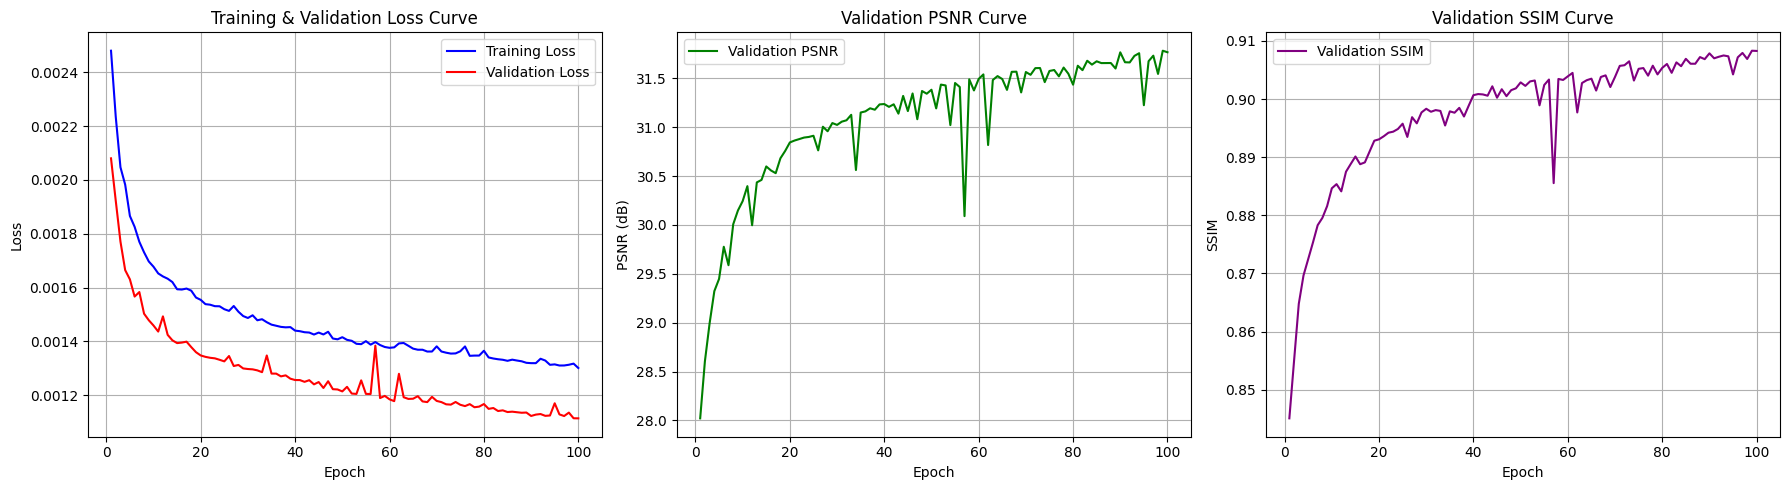

Time taken to train is: 218.37 minutes


In [17]:
import time
start_time = time.time()
trainedModel = train(model, train_loader, val_loader, epochs=100, lr=1e-4, log_dir="/kaggle/working/runs/RestormerTinyHT")
end_time = time.time()

print(f"Time taken to train is: {(end_time - start_time) / 60:.2f} minutes")

In [19]:
torch.save(trainedModel.state_dict(), "restormerTinyAttention.pth")

# Inference

In [3]:
# Original Restormer-Tiny components (adapted from official code and paper)
import torch
import torch.nn as nn
import torch.nn.functional as F

class LayerNorm2d(nn.Module):
    def __init__(self, num_channels, eps=1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mu = x.mean(1, keepdim=True)
        sigma = ((x - mu) ** 2).mean(1, keepdim=True)
        x = (x - mu) / torch.sqrt(sigma + self.eps)
        return self.weight[:, None, None] * x + self.bias[:, None, None]

class MDTA(nn.Module):
    def __init__(self, dim, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.temperature = nn.Parameter(torch.ones(num_heads, 1, 1))

        self.qkv = nn.Conv2d(dim, dim * 3, kernel_size=1, bias=False)
        self.qkv_dwconv = nn.Conv2d(dim * 3, dim * 3, kernel_size=3, stride=1, padding=1, groups=dim * 3, bias=False)
        self.project_out = nn.Conv2d(dim, dim, kernel_size=1, bias=False)

    def forward(self, x):
        B, C, H, W = x.shape
        qkv = self.qkv_dwconv(self.qkv(x))
        q, k, v = qkv.chunk(3, dim=1)

        q = q.reshape(B, self.num_heads, C // self.num_heads, H * W)
        k = k.reshape(B, self.num_heads, C // self.num_heads, H * W)
        v = v.reshape(B, self.num_heads, C // self.num_heads, H * W)

        q = F.normalize(q, dim=2)
        k = F.normalize(k, dim=2)

        attn = (q @ k.transpose(-2, -1)) * self.temperature
        attn = attn.softmax(dim=-1)

        out = attn @ v
        out = out.reshape(B, C, H, W)
        out = self.project_out(out)
        return out

class GatedFFN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        hidden_dim = dim * 2
        self.project_in = nn.Conv2d(dim, hidden_dim * 2, kernel_size=1, bias=False)
        self.dwconv = nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, stride=1, padding=1, groups=hidden_dim * 2, bias=False)
        self.project_out = nn.Conv2d(hidden_dim, dim, kernel_size=1, bias=False)

    def forward(self, x):
        x = self.project_in(x)
        x = self.dwconv(x)
        x1, x2 = x.chunk(2, dim=1)
        x = F.gelu(x1) * x2
        x = self.project_out(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.norm1 = LayerNorm2d(dim)
        self.attn = MDTA(dim, num_heads)
        self.norm2 = LayerNorm2d(dim)
        self.ffn = GatedFFN(dim)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.ffn(self.norm2(x))
        return x




In [4]:
# ============ Restormer-Tiny ============
class RestormerTiny(nn.Module):
    def __init__(self, dim=32, num_blocks=4, scale=2, num_heads=2):
        super().__init__()
        self.shallow_feat = nn.Conv2d(3, dim, kernel_size=3, padding=1)
        self.transformer_blocks = nn.Sequential(*[TransformerBlock(dim, num_heads) for _ in range(num_blocks)])
        self.upsample = nn.Sequential(
            nn.Conv2d(dim, dim * (scale ** 2), 3, 1, 1),
            nn.PixelShuffle(scale),
            nn.Conv2d(dim, 3, 3, 1, 1)
        )

    def forward(self, x):
        x = self.shallow_feat(x)
        x = self.transformer_blocks(x)
        x = self.upsample(x)
        return x



In [5]:
class DIV2KDataset(Dataset):
    def __init__(self, hr_dir, scale=2, transform=None):
        super().__init__()
        self.hr_images = [os.path.join(hr_dir, f) for f in os.listdir(hr_dir) if f.endswith(".png")]
        self.scale = scale
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr = Image.open(self.hr_images[idx]).convert("RGB")
        w, h = hr.size
        hr = hr.crop((0, 0, w - w % self.scale, h - h % self.scale))
        lr = hr.resize((w // self.scale, h // self.scale), Image.BICUBIC)
        return self.transform(lr), self.transform(hr)

In [5]:
model = RestormerTiny(dim=32, num_blocks=4, scale=2)
model.load_state_dict(torch.load("restormerTinyAttention.pth"))
model.eval()


RestormerTiny(
  (shallow_feat): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (norm1): LayerNorm2d()
      (attn): MDTA(
        (qkv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (qkv_dwconv): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=96, bias=False)
        (project_out): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (norm2): LayerNorm2d()
      (ffn): GatedFFN(
        (project_in): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (dwconv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
        (project_out): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): TransformerBlock(
      (norm1): LayerNorm2d()
      (attn): MDTA(
        (qkv): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (q

In [6]:
transform = transforms.ToTensor()

    # Load the full dataset (800 images assumed)
full_dataset = DIV2KDataset("./comparison_images", transform=transform, scale=2)

    # Dataloaders
val_loader = DataLoader(full_dataset, batch_size=1)

In [7]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def tensor_to_cv2_img(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()  # [H, W, C]
    img = np.clip(img * 255.0, 0, 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

def tensor_to_gray_numpy(tensor_img):
    img = tensor_img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    img_gray = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    return img_gray

# Loop through the first 4 examples
for idx, (lr_img, hr_img) in enumerate(val_loader):
    if idx >= 4:
        break

    lr_img = lr_img.squeeze(0)
    hr_img = hr_img.squeeze(0)

    with torch.no_grad():
        sr_img = model(lr_img.unsqueeze(0).to(device))
    sr_img = sr_img.squeeze(0).cpu()

    # Convert to OpenCV images
    lr_img_cv2 = tensor_to_cv2_img(lr_img)
    hr_img_cv2 = tensor_to_cv2_img(hr_img)
    sr_img_cv2 = tensor_to_cv2_img(sr_img)

    # Save the images
    cv2.imwrite(f"Restormer-TinyATTlr_img_{idx+1}.png", lr_img_cv2)
    cv2.imwrite(f"Restormer-TinyATTsr_img_{idx+1}.png", sr_img_cv2)
    cv2.imwrite(f"Restormer-TinyATThr_img_{idx+1}.png", hr_img_cv2)

    # Calculate metrics
    hr_gray = tensor_to_gray_numpy(hr_img)
    sr_gray = tensor_to_gray_numpy(sr_img)
    psnr_value = psnr(hr_img_cv2, sr_img_cv2, data_range=255)
    ssim_value = ssim(hr_gray, sr_gray, data_range=255)

    print(f"Example {idx+1}")
    print(f"PSNR: {psnr_value:.2f} dB")
    print(f"SSIM: {ssim_value:.4f}")
    print("=" * 30)

    # Show the images
    cv2.imshow(f'LR {idx+1}', lr_img_cv2)
    cv2.imshow(f'SR {idx+1}', sr_img_cv2)
    cv2.imshow(f'HR {idx+1}', hr_img_cv2)

    cv2.waitKey(0)
    cv2.destroyAllWindows()


Example 1
PSNR: 38.88 dB
SSIM: 0.9688
Example 2
PSNR: 38.90 dB
SSIM: 0.9752
Example 3
PSNR: 36.03 dB
SSIM: 0.8396
Example 4
PSNR: 39.36 dB
SSIM: 0.9528


#### These images are stored in for_comparison folder